In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
dates = []
times = []
sensor_ids = []
statuses = []
activities = []

with open('data', 'r') as file:

    for line in file:
        columns = re.split(r'\s+', line.strip())

        if len(columns) >= 4:
            date = columns[0]
            time = columns[1]
            sensor_id = columns[2]
            status = columns[3]
            activity = ' '.join(columns[4:]) if len(columns) > 4 else ""

            dates.append(date)
            times.append(time)
            sensor_ids.append(sensor_id)
            statuses.append(status)
            activities.append(activity)

data = pd.DataFrame({
    'Date': dates,
    'Time': times,
    'Sensor_ID': sensor_ids,
    'Status': statuses,
    'Activity': activities
})

print(data)

               Date             Time Sensor_ID Status        Activity
0        2010-11-04  00:03:50.209589      M003     ON  Sleeping begin
1        2010-11-04  00:03:57.399391      M003    OFF                
2        2010-11-04  00:15:08.984841      T002   21.5                
3        2010-11-04  00:30:19.185547      T003     21                
4        2010-11-04  00:30:19.385336      T004     21                
...             ...              ...       ...    ...             ...
1719553  2011-06-11   23:42:59.28507      T002   25.5                
1719554  2011-06-11  23:48:02.888409      T001   23.5                
1719555  2011-06-11  23:48:02.988798      T002     25                
1719556  2011-06-11    23:53:06.4292      T002   25.5                
1719557  2011-06-11  23:58:10.004834      T002     25    Sleeping end

[1719558 rows x 5 columns]


In [ ]:
unique_dates = data['Date'].unique()
print(len(unique_dates))

220


**DATA PREPROCESSING**

In [ ]:
# Drop the 'Sensor_ID' and 'Status' columns
data = data.drop(['Sensor_ID', 'Status','Time'], axis=1)

data = data[data['Activity'] != '']


In [ ]:
# Remove the 'respirate' activity from the 'Activity' column
data = data[data['Activity'] != 'Respirate begin']
data = data[data['Activity'] != 'Respirate end']

In [ ]:
# Drop the rows with activities ending with 'end'
data = data[~data['Activity'].str.endswith('end')]

In [ ]:
duplicated_rows = data['Activity'].shift() == data['Activity']
data = data[~duplicated_rows]

In [ ]:
data['Activity'] = data['Activity'].str.replace(' begin', '')

In [ ]:
date_data = data[data['Date'] == '2011-05-23']

num_rows = len(date_data)

middle_index = num_rows // 2

date_data = date_data.iloc[:middle_index]

data[data['Date'] == '2011-05-23'] = date_data

data = data.dropna()

activity_counts_per_date = data['Date'].value_counts()
dates_to_keep = activity_counts_per_date[activity_counts_per_date >= 5].index
data = data[data['Date'].isin(dates_to_keep)]

print(data)

               Date          Activity
0        2010-11-04          Sleeping
52       2010-11-04     Bed_to_Toilet
68       2010-11-04          Sleeping
266      2010-11-04  Meal_Preparation
934      2010-11-04             Relax
...             ...               ...
1716681  2011-06-11             Relax
1718341  2011-06-11              Work
1718402  2011-06-11  Meal_Preparation
1718684  2011-06-11             Relax
1719500  2011-06-11          Sleeping

[3916 rows x 2 columns]


Split data

In [ ]:
unique_dates = data['Date'].unique()

num_unique_dates = len(unique_dates)

train_split_index = int(num_unique_dates * 0.14)
val_split_index = int(num_unique_dates * 0.28)

train_data = data[data['Date'] <= unique_dates[train_split_index]]
val_data = data[(data['Date'] > unique_dates[train_split_index]) & (data['Date'] <= unique_dates[val_split_index])]
test_data = data[data['Date'] > unique_dates[val_split_index]]

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

unique = test_data['Date'].unique()
print(len(unique))

pd.set_option('display.max_rows', None)
print(test_data)

157
            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07

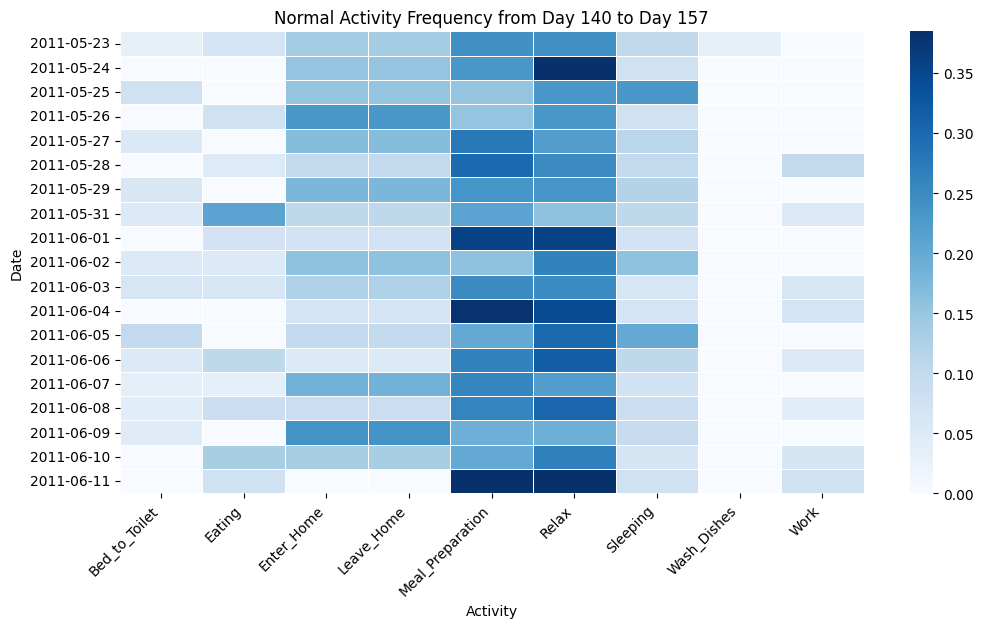

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'test_data' with columns 'Date' and 'Activity'
# Make sure 'Date' column is in datetime format

# Filter the test data for days 140 to 158
start_date = unique_dates[val_split_index + 139]
end_date = unique_dates[val_split_index + 157]
filtered_data = test_data[(test_data['Date'] >= start_date) & (test_data['Date'] <= end_date)]

# Create a pivot table for activity counts
activity_counts = filtered_data.pivot_table(index='Date', columns='Activity', aggfunc='size', fill_value=0)

# Normalize the activity counts for better visualization
activity_freq = activity_counts.div(activity_counts.sum(axis=1), axis=0)

# Set up the figure
plt.figure(figsize=(12, 6))

# Create a heatmap using seaborn
sns.heatmap(activity_freq, cmap="Blues", linewidths=0.5, linecolor='white')

# Customize labels and title
plt.xlabel('Activity')
plt.ylabel('Date')
plt.title('Normal Activity Frequency from Day 140 to Day 157')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()



In [ ]:
sleep_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 79]) &
                             (test_data['Date'] <= unique_dates[val_split_index + 98])]

random_sleep_days = random.sample(list(sleep_days['Date'].unique()), 10)

modified_dfs = []

for date, day_data in sleep_days.groupby('Date'):
    if date in random_sleep_days:
        print(f"Anomaly introduced for date: {date}") 

        anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(anomaly_sequence),
                                                   'Activity': anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            modified_dfs.append(modified_df)
        else:
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(anomaly_sequence),
                                                   'Activity': anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            modified_dfs.append(modified_df)
    else:
        modified_dfs.append(day_data)

sleep_days = pd.concat(modified_dfs, ignore_index=True)

test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 79]],
                       sleep_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 98]]])


Anomaly introduced for date: 2011-03-24
Anomaly introduced for date: 2011-03-25
Anomaly introduced for date: 2011-03-26
Anomaly introduced for date: 2011-03-27
Anomaly introduced for date: 2011-03-29
Anomaly introduced for date: 2011-03-31
Anomaly introduced for date: 2011-04-02
Anomaly introduced for date: 2011-04-03
Anomaly introduced for date: 2011-04-06
Anomaly introduced for date: 2011-04-09


In [ ]:
print(random_sleep_days)


['2011-04-02', '2011-04-09', '2011-03-29', '2011-03-25', '2011-03-26', '2011-03-31', '2011-03-27', '2011-04-06', '2011-03-24', '2011-04-03']


In [ ]:
unique = sleep_days['Date'].unique()
print(unique)

['2011-03-24' '2011-03-25' '2011-03-26' '2011-03-27' '2011-03-28'
 '2011-03-29' '2011-03-30' '2011-03-31' '2011-04-01' '2011-04-02'
 '2011-04-03' '2011-04-04' '2011-04-05' '2011-04-06' '2011-04-07'
 '2011-04-08' '2011-04-09' '2011-04-10' '2011-04-11' '2011-04-12']


In [ ]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

In [ ]:
# Step 1: Identify the data in the test dataset from day 100 to 114 and isolate it
sleep_repeat_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 99]) &
                         (test_data['Date'] <= unique_dates[val_split_index + 113])]

# Step 2: Randomly select 7 days to introduce the anomalies
random_sleep_repeat_days = random.sample(list(sleep_repeat_days['Date'].unique()), 8)

# Step 3: Simulate the anomalies for unorganized activity pattern
modified_dfs = []

for date, day_data in sleep_repeat_days.groupby('Date'):
    if date in random_sleep_repeat_days:
        print(f"Anomaly introduced for date: {date}")  # Print the date with the anomalies

        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            # Insert the sleep anomaly sequence after the first activity
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            # Insert the sleep anomaly sequence before the first activity
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df

        # Define the repetitive activities sequence
        repetitive_sequence = ['Meal_Preparation', 'Relax', 'Meal_Preparation','Eating','Relax','Eating']

        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        modified_dfs.append(modified_df)
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
sleep_repeat_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 99]],
                       sleep_repeat_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 113]]])

Anomaly introduced for date: 2011-04-14
Anomaly introduced for date: 2011-04-16
Anomaly introduced for date: 2011-04-19
Anomaly introduced for date: 2011-04-20
Anomaly introduced for date: 2011-04-22
Anomaly introduced for date: 2011-04-23
Anomaly introduced for date: 2011-04-25
Anomaly introduced for date: 2011-04-26


In [ ]:
# Step 1: Identify the data in the test dataset from day 115 to 119 and isolate it
sleep_housekeeping_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 114]) &
                         (test_data['Date'] <= unique_dates[val_split_index + 118])]

# Step 2: Randomly select 7 days to introduce the anomalies
random_sleep_housekeeping_days = random.sample(list(sleep_housekeeping_days['Date'].unique()), 2)

# Step 3: Simulate the anomalies for unorganized activity pattern
modified_dfs = []

for date, day_data in sleep_housekeeping_days.groupby('Date'):
    if date in random_sleep_housekeeping_days:
        print(f"Anomaly introduced for date: {date}")  # Print the date with the anomalies

        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            # Insert the sleep anomaly sequence after the first activity
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            # Insert the sleep anomaly sequence before the first activity
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df

        # Define the repetitive activities sequence
        repetitive_sequence = ['Housekeeping', 'Relax', 'Meal_Preparation','Eating','Housekeeping','Wash_Dishes','Relax']

        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        modified_dfs.append(modified_df)
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
sleep_housekeeping_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 114]],
                       sleep_housekeeping_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 118]]])

Anomaly introduced for date: 2011-04-28
Anomaly introduced for date: 2011-05-02


In [ ]:
unique = sleep_repeat_days['Date'].unique()
print(unique)

['2011-04-13' '2011-04-14' '2011-04-15' '2011-04-16' '2011-04-17'
 '2011-04-18' '2011-04-19' '2011-04-20' '2011-04-21' '2011-04-22'
 '2011-04-23' '2011-04-24' '2011-04-25' '2011-04-26' '2011-04-27']


In [ ]:
unique = sleep_housekeeping_days['Date'].unique()
print(unique)

['2011-04-28' '2011-04-29' '2011-04-30' '2011-05-01' '2011-05-02']


In [ ]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

Sleep Interruption + Repetitive + Relaxing (Day 120 to 139 - Total 20 days)

In [ ]:
# Step 1: Identify the data in the test dataset from day 110 to 119 and isolate it
relax_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 119]) &
                       (test_data['Date'] <= unique_dates[val_split_index + 138])]

# Step 2: Randomly select 2 days to introduce the anomalies
random_relax_days = random.sample(list(relax_days['Date'].unique()), 10)

# Step 3: Simulate the anomalies
modified_dfs = []

for date, day_data in relax_days.groupby('Date'):
    if date in random_relax_days:
        print(f"Anomaly introduced for date: {date}")

        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df

        # Define the repetitive activities sequence
        repetitive_sequence = ['Meal_Preparation', 'Relax', 'Meal_Preparation','Eating','Relax','Eating']

        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        day_data = modified_df

        # Simulate relaxing instances spread throughout the day
        relaxing_activities = ['Relax'] * 3
        num_time_slots = len(day_data) - len(relaxing_activities) + 1
        insertion_indices = random.sample(range(num_time_slots), len(relaxing_activities))

        modified_day_data = []

        for i, row in day_data.iterrows():
            modified_day_data.append(row)

            if i in insertion_indices:
               relaxing_activity = relaxing_activities.pop(0)
               relaxing_row = pd.Series({'Date': date, 'Activity': relaxing_activity})
               modified_day_data.append(relaxing_row)

        modified_dfs.append(pd.DataFrame(modified_day_data))
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
relax_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 119]],
                       relax_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 138]]])


Anomaly introduced for date: 2011-05-08
Anomaly introduced for date: 2011-05-09
Anomaly introduced for date: 2011-05-10
Anomaly introduced for date: 2011-05-11
Anomaly introduced for date: 2011-05-12
Anomaly introduced for date: 2011-05-14
Anomaly introduced for date: 2011-05-16
Anomaly introduced for date: 2011-05-17
Anomaly introduced for date: 2011-05-21
Anomaly introduced for date: 2011-05-22


In [ ]:
unique = relax_days['Date'].unique()
print(unique)

['2011-05-03' '2011-05-04' '2011-05-05' '2011-05-06' '2011-05-07'
 '2011-05-08' '2011-05-09' '2011-05-10' '2011-05-11' '2011-05-12'
 '2011-05-13' '2011-05-14' '2011-05-15' '2011-05-16' '2011-05-17'
 '2011-05-18' '2011-05-19' '2011-05-20' '2011-05-21' '2011-05-22']


In [ ]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

Sleep interruption + Repetitive + Relax + Napping (Day 140 to 158 - 19 days)

In [ ]:
# Step 1: Identify the data in the test dataset from day 120 to 158 and isolate it
dementia_days = test_data[(test_data['Date'] >= unique_dates[val_split_index + 139]) &
                       (test_data['Date'] <= unique_dates[val_split_index + 157])]

# Step 2: Randomly select 2 days to introduce the anomalies
random_dementia_days = random.sample(list(dementia_days['Date'].unique()), 9)

# Step 3: Simulate the anomalies
modified_dfs = []

for date, day_data in dementia_days.groupby('Date'):
    if date in random_dementia_days:
        print(f"Anomaly introduced for date: {date}")

        # Simulate sleep disruption by inserting the sleep anomaly sequence
        sleep_anomaly_sequence = ['Bed_to_Toilet', 'Eating', 'Sleeping']
        if day_data['Activity'].iloc[0] == 'Sleeping':
            modified_df = pd.concat([day_data.iloc[:1],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data.iloc[1:]],
                                    ignore_index=True)
            day_data = modified_df
        else:
            modified_df = pd.concat([day_data.iloc[:0],
                                     pd.DataFrame({'Date': [date] * len(sleep_anomaly_sequence),
                                                   'Activity': sleep_anomaly_sequence}),
                                     day_data],
                                    ignore_index=True)
            day_data = modified_df

        # Define the repetitive activities sequence
        repetitive_sequence = ['Sleeping','Meal_Preparation', 'Relax', 'Meal_Preparation','Eating','Relax','Eating','Sleeping']

        # Insert the repetitive sequence in the middle of the day
        insertion_index = len(day_data) // 2
        modified_df = pd.concat([day_data.iloc[:insertion_index],
                                 pd.DataFrame({'Date': [date] * len(repetitive_sequence),
                                               'Activity': repetitive_sequence}),
                                 day_data.iloc[insertion_index:]],
                                ignore_index=True)
        day_data = modified_df

        # Simulate relaxing instances spread throughout the day
        relaxing_activities = ['Relax'] * 3
        num_time_slots = len(day_data) - len(relaxing_activities) + 1
        insertion_indices = random.sample(range(num_time_slots), len(relaxing_activities))

        modified_day_data = []

        for i, row in day_data.iterrows():
            modified_day_data.append(row)

            if i in insertion_indices:
                relaxing_activity = relaxing_activities.pop(0)
                relaxing_row = pd.Series({'Date': date, 'Activity': relaxing_activity})
                modified_day_data.append(relaxing_row)

        modified_dfs.append(pd.DataFrame(modified_day_data))
    else:
        modified_dfs.append(day_data)

# Combine the modified dataframes back into a single dataframe
dementia_days = pd.concat(modified_dfs, ignore_index=True)

# Concatenate the modified selected days data back into the test_data DataFrame
test_data = pd.concat([test_data[test_data['Date'] < unique_dates[val_split_index + 139]],
                       dementia_days,
                       test_data[test_data['Date'] > unique_dates[val_split_index + 157]]])

Anomaly introduced for date: 2011-05-23
Anomaly introduced for date: 2011-05-25
Anomaly introduced for date: 2011-05-28
Anomaly introduced for date: 2011-05-29
Anomaly introduced for date: 2011-06-03
Anomaly introduced for date: 2011-06-04
Anomaly introduced for date: 2011-06-06
Anomaly introduced for date: 2011-06-08
Anomaly introduced for date: 2011-06-10


In [ ]:
unique = dementia_days['Date'].unique()
print(unique)

['2011-05-23' '2011-05-24' '2011-05-25' '2011-05-26' '2011-05-27'
 '2011-05-28' '2011-05-29' '2011-05-31' '2011-06-01' '2011-06-02'
 '2011-06-03' '2011-06-04' '2011-06-05' '2011-06-06' '2011-06-07'
 '2011-06-08' '2011-06-09' '2011-06-10' '2011-06-11']


In [ ]:
print(test_data)

            Date          Activity
0     2011-01-05          Sleeping
1     2011-01-05     Bed_to_Toilet
2     2011-01-05          Sleeping
3     2011-01-05  Meal_Preparation
4     2011-01-05             Relax
5     2011-01-05  Meal_Preparation
6     2011-01-05            Eating
7     2011-01-05        Leave_Home
8     2011-01-05        Enter_Home
9     2011-01-05             Relax
10    2011-01-05        Leave_Home
11    2011-01-05        Enter_Home
12    2011-01-05             Relax
13    2011-01-05          Sleeping
14    2011-01-06  Meal_Preparation
15    2011-01-06             Relax
16    2011-01-06        Leave_Home
17    2011-01-06        Enter_Home
18    2011-01-06  Meal_Preparation
19    2011-01-06            Eating
20    2011-01-06        Leave_Home
21    2011-01-06        Enter_Home
22    2011-01-06  Meal_Preparation
23    2011-01-06             Relax
24    2011-01-06  Meal_Preparation
25    2011-01-06             Relax
26    2011-01-07          Sleeping
27    2011-01-07    

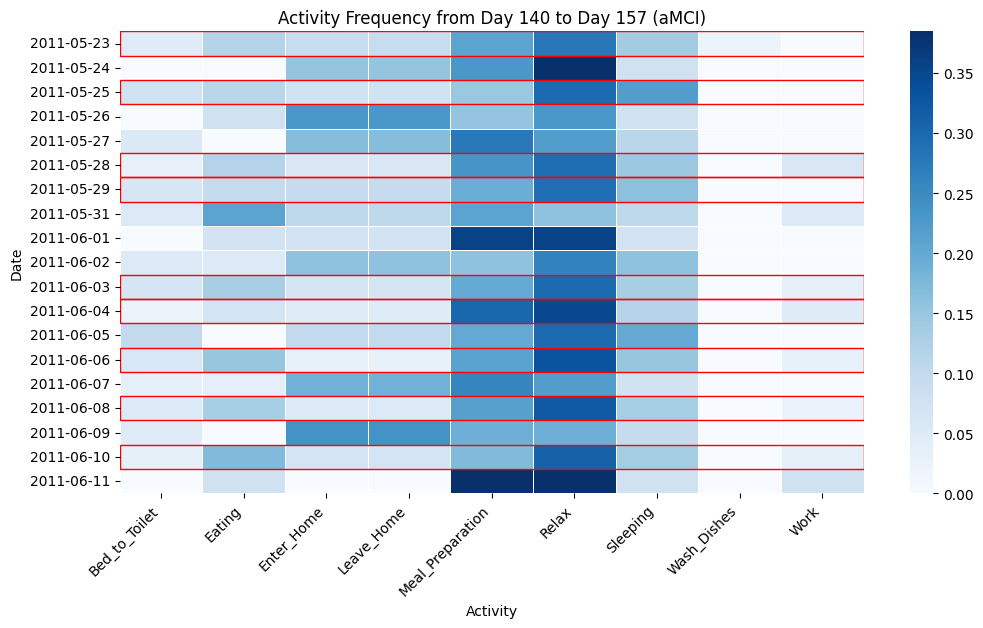

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'test_data' with columns 'Date' and 'Activity'
# Make sure 'Date' column is in datetime format

# Filter the test data for days 140 to 158
start_date = unique_dates[val_split_index + 139]
end_date = unique_dates[val_split_index + 157]
filtered_data = test_data[(test_data['Date'] >= start_date) & (test_data['Date'] <= end_date)]

# Create a pivot table for activity counts
activity_counts = filtered_data.pivot_table(index='Date', columns='Activity', aggfunc='size', fill_value=0)

# Normalize the activity counts for better visualization
activity_freq = activity_counts.div(activity_counts.sum(axis=1), axis=0)

# Set up the figure and axes
plt.figure(figsize=(12, 6))
ax = sns.heatmap(activity_freq, cmap="Blues", linewidths=0.5, linecolor='white')

# Customize labels and title
plt.xlabel('Activity')
plt.ylabel('Date')
plt.title('Activity Frequency from Day 140 to Day 157 (aMCI)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Get the list of anomalous dates
anomalous_dates = []
for date in test_data['Date'].unique():
    if date in random_sleep_days or \
       date in random_sleep_repeat_days or \
       date in random_sleep_housekeeping_days or \
       date in random_relax_days or \
       date in random_dementia_days:
        anomalous_dates.append(date)

# Convert anomalous dates to datetime objects
anomalous_dates = [pd.to_datetime(date) for date in anomalous_dates]

# Set the modified y-axis tick labels
ytick_labels = [date.strftime('%Y-%m-%d') for date in pd.to_datetime(activity_freq.index)]
ax.set_yticklabels(ytick_labels)

# Add black outline for rows with anomalous dates
for idx, date in enumerate(pd.to_datetime(activity_freq.index)):
    if date in anomalous_dates:
        ax.add_patch(plt.Rectangle((0, idx), activity_freq.shape[1], 1, fill=False, edgecolor='red'))

# Show the plot
plt.show()

In [ ]:
print(data.columns)


Index(['Date', 'Activity'], dtype='object')


In [ ]:
# Create reverse mapping: activity name → encoded value
activity_decoder = {v: k for k, v in activity_encoder.items()}

# Apply encoding
train_data['Encoded_Activity'] = train_data['Activity'].map(activity_decoder)
val_data['Encoded_Activity'] = val_data['Activity'].map(activity_decoder)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        fc_output = self.fc(out)
        return fc_output

activity_encoder = {
    0: 'Bed_to_Toilet',
    1: 'Eating',
    2: 'Enter_Home',
    3: 'Housekeeping',
    4: 'Leave_Home',
    5: 'Meal_Preparation',
    6: 'Relax',
    7: 'Sleeping',
    8: 'Wash_Dishes',
    9: 'Work',
    10: 'EoS'
}

# Convert train sequences to processed tensors
processed_train_sequences = []
for date, group in train_data.groupby('Date'):
    sequence = group['Encoded_Activity'].tolist()
    sequence.append(10)  # Add EoS symbol
    processed_train_sequences.extend(sequence)

# Segment sequences using sliding window
window_size = 5
train_segments = []
for i in range(0, len(processed_train_sequences) - window_size):
    window = processed_train_sequences[i : i + window_size]
    target_activity = processed_train_sequences[i + window_size]

    # Create a one-hot vector for the target
    target_one_hot = torch.zeros(len(activity_encoder))  # Create a zero-filled vector of length 11
    target_one_hot[target_activity] = 1  # Set the target activity index to 1

    train_segments.append((window, target_one_hot))

# Convert val sequences to processed tensors
processed_val_sequences = []
for date, group in val_data.groupby('Date'):
    sequence = group['Encoded_Activity'].tolist()
    sequence.append(10)  # Add EoS symbol
    processed_val_sequences.extend(sequence)

# Segment sequences using sliding window for validation data
val_segments = []
for i in range(0, len(processed_val_sequences) - window_size):
    window = processed_val_sequences[i : i + window_size]
    target_activity = processed_val_sequences[i + window_size]

    # Create a one-hot vector for the target
    target_one_hot = torch.zeros(len(activity_encoder))  # Create a zero-filled vector of length 11
    target_one_hot[target_activity] = 1  # Set the target activity index to 1

    val_segments.append((window, target_one_hot))


In [ ]:
# Instantiate the LSTM model
input_size = 5
hidden_size = 128
num_layers = 4
output_size = len(activity_encoder)
num_epochs = 50
batch_size = 10
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

train_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in train_segments]
windows, targets = zip(*train_data_tensors)
targets = [target.view(1, -1) for target in targets]
train = TensorDataset(torch.stack(windows), torch.cat(targets))
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)

val_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in val_segments]
val_windows, val_targets = zip(*val_data_tensors)
val_targets = [target.view(1, -1) for target in val_targets]
val_dataset = TensorDataset(torch.stack(val_windows), torch.cat(val_targets))
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()

        sequences, targets = batch
        sequences = sequences.unsqueeze(1).to(torch.float32)  

        # Detach hidden states from previous iteration
        lstm_model.lstm.flatten_parameters()

        outputs = lstm_model(sequences)

        # Modify targets to contain class indices
        targets = torch.argmax(targets, dim=1)

        loss = criterion(outputs.view(-1, output_size), targets)  # Reshape the targets tensor
        loss.backward()
        optimizer.step()

     # Validation loop
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sequences, targets = batch
            sequences = sequences.unsqueeze(1).to(torch.float32)

            lstm_model.lstm.flatten_parameters()
            outputs = lstm_model(sequences)

            # Modify targets to contain class indices
            val_targets = torch.argmax(targets, dim=1)

            loss = criterion(outputs.view(-1, output_size), val_targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average validation loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

<ipython-input-43-06567a42c08f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in train_segments]
<ipython-input-43-06567a42c08f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long)) for window, target in val_segments]


Epoch [1/50], Loss: 2.5504, Val Loss: 2.1072
Epoch [2/50], Loss: 2.5136, Val Loss: 2.0962
Epoch [3/50], Loss: 2.4581, Val Loss: 2.0566
Epoch [4/50], Loss: 2.5660, Val Loss: 2.0551
Epoch [5/50], Loss: 2.6712, Val Loss: 2.0215
Epoch [6/50], Loss: 2.8757, Val Loss: 1.9317
Epoch [7/50], Loss: 2.9340, Val Loss: 1.7926
Epoch [8/50], Loss: 2.4979, Val Loss: 1.5100
Epoch [9/50], Loss: 2.3826, Val Loss: 1.4149
Epoch [10/50], Loss: 2.2971, Val Loss: 1.3281
Epoch [11/50], Loss: 2.2167, Val Loss: 1.3455
Epoch [12/50], Loss: 2.1550, Val Loss: 1.3630
Epoch [13/50], Loss: 2.1603, Val Loss: 1.3546
Epoch [14/50], Loss: 2.1268, Val Loss: 1.3142
Epoch [15/50], Loss: 2.0327, Val Loss: 1.3140
Epoch [16/50], Loss: 2.0148, Val Loss: 1.2401
Epoch [17/50], Loss: 1.9011, Val Loss: 1.1801
Epoch [18/50], Loss: 1.8583, Val Loss: 1.1653
Epoch [19/50], Loss: 1.7753, Val Loss: 1.1660
Epoch [20/50], Loss: 1.7094, Val Loss: 1.1527
Epoch [21/50], Loss: 1.6559, Val Loss: 1.1527
Epoch [22/50], Loss: 1.6114, Val Loss: 1.15

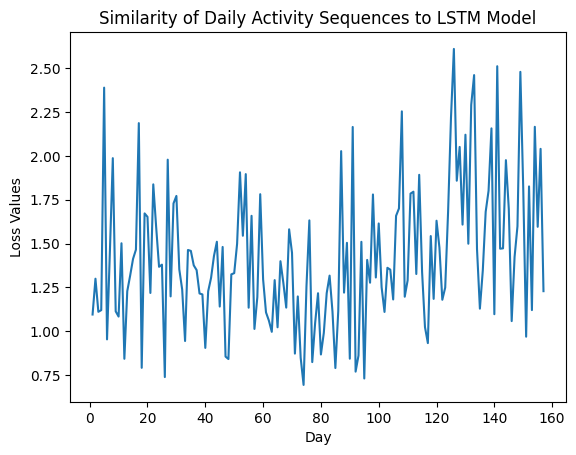

In [ ]:
test_error_values = []
window_size = 5
lstm_model.eval()  # Set the model to evaluation mode
# Create reverse mapping from activity name to integer
activity_decoder = {v: k for k, v in activity_encoder.items()}

# Map activity names to integers
test_data['Encoded_Activity'] = test_data['Activity'].map(activity_decoder)

with torch.no_grad():
    for date, group in test_data.groupby('Date'):
        processed_test_sequences = []
        test_sequences = group['Encoded_Activity'].tolist()
        test_sequences.append(10)  # Add EoS symbol
        processed_test_sequences.extend(test_sequences)

        # Segment sequences using sliding window
        test_segments = []
        for i in range(0, len(processed_test_sequences) - window_size):
            window = processed_test_sequences[i : i + window_size]
            target = processed_test_sequences[i + window_size]
            test_segments.append((window, target))

        # Create DataLoader for test data
        test_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long))
                             for window, target in test_segments]

        windows, targets = zip(*test_data_tensors)

        test = TensorDataset(torch.stack(windows), torch.stack(targets))

        test_loader = DataLoader(dataset=test, batch_size=1, shuffle=False)

        # Calculate loss values for each sequence
        sequence_loss_values = []
        for batch in test_loader:
            sequences, target = batch
            sequences = sequences.unsqueeze(0).to(torch.float32)

            outputs = lstm_model(sequences)

            loss = criterion(outputs.view(-1, output_size), target)  # Use class index as target

            sequence_loss_values.append(loss.item())

        # Calculate the average sliding window error value for the day
        average_test_loss = sum(sequence_loss_values) / len(sequence_loss_values)
        test_error_values.append(average_test_loss)
        sequence_loss_values = []

# Plot average error values against days
plt.plot(range(1, len(test_data['Date'].unique()) + 1), test_error_values)
plt.xlabel('Day')
plt.ylabel('Loss Values')
plt.title('Similarity of Daily Activity Sequences to LSTM Model')
plt.show()


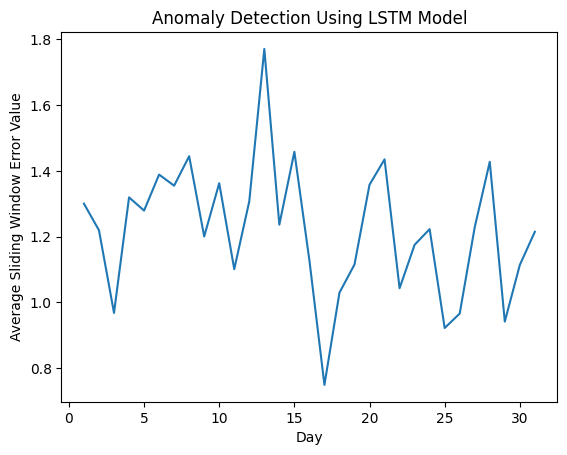

In [ ]:
# Calculate error values for each day
val_error_values = []
window_size = 5
lstm_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for date, group in val_data.groupby('Date'):
        processed_val_sequences = []
        val_sequences = group['Encoded_Activity'].tolist()
        val_sequences.append(10)  # Add EoS symbol
        processed_val_sequences.extend(val_sequences)

        # Segment sequences using sliding window
        val_segments = []
        for i in range(0, len(processed_val_sequences) - window_size):
            window = processed_val_sequences[i : i + window_size]
            target = processed_val_sequences[i + window_size]
            val_segments.append((window, target))

        # Create DataLoader for val data
        val_data_tensors = [(torch.tensor(window, dtype=torch.long), torch.tensor(target, dtype=torch.long))
                             for window, target in val_segments]

        windows, targets = zip(*val_data_tensors)

        val = TensorDataset(torch.stack(windows), torch.stack(targets))

        val_loader = DataLoader(dataset=val, batch_size=1, shuffle=False)

        # Calculate loss values for each sequence
        sequence_loss_values = []
        for batch in val_loader:
            sequences, target = batch
            sequences = sequences.unsqueeze(0).to(torch.float32)

            outputs = lstm_model(sequences)

            loss = criterion(outputs.view(-1, output_size), target)  # Use class index as target

            sequence_loss_values.append(loss.item())

        # Calculate the average sliding window error value for the day
        average_val_loss = sum(sequence_loss_values) / len(sequence_loss_values)
        val_error_values.append(average_val_loss)

# Plot average error values against days
plt.plot(range(1, len(val_data['Date'].unique()) + 1), val_error_values)
plt.xlabel('Day')
plt.ylabel('Average Sliding Window Error Value')
plt.title('Anomaly Detection Using LSTM Model')
plt.show()

val_min = min(val_error_values)
val_max = max(val_error_values)

In [ ]:
# Extract the true labels for anomalies in the test dataset
true_labels = []

for date in test_data['Date'].unique():
    if date in random_sleep_days or \
       date in random_sleep_repeat_days or \
       date in random_sleep_housekeeping_days or \
       date in random_relax_days or \
       date in random_dementia_days:
        true_labels.append(1)  # Anomaly introduced
    else:
        true_labels.append(0)  # Normal behavior
# Linearly sample 1000 threshold choices
threshold_choices = np.linspace(val_min, val_max, num=3000)

# Initialize variables to store the best threshold and its corresponding F1 score
best_threshold = None
best_f1_score = None

# Iterate over the threshold choices
for threshold in threshold_choices:
    # Classify the data instances as anomalous or non-anomalous based on the threshold
    predicted_labels = np.where(test_error_values <= threshold, 0, 1)

    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels)

    # Update the best threshold and F1 score if necessary
    if best_f1_score is None or f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

# Print the best threshold and its corresponding F1 score
print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Best Threshold: 1.6524583089140115
Best F1 Score: 0.6075949367088608


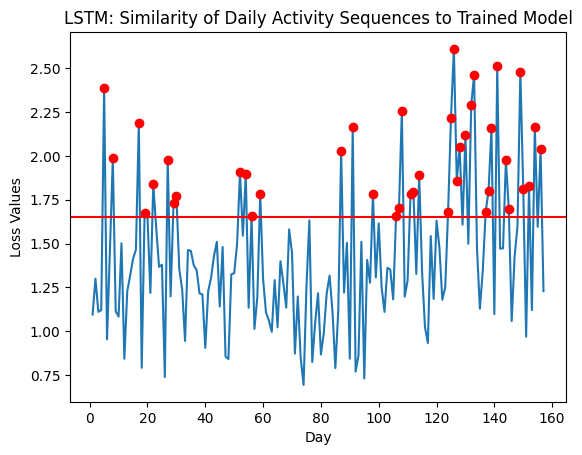

In [ ]:
# Identify the anomalies by comparing the log-likelihoods to the threshold
anomalies = np.where(np.array(test_error_values) >= best_threshold)[0]

# Plot the log-likelihoods against the day
plt.plot(range(1, len(test_data['Date'].unique()) + 1), test_error_values)

# Plot the threshold line and color the anomalies
plt.axhline(y=best_threshold, color='r', linestyle='-')
for anomaly in anomalies:
    plt.plot(anomaly + 1, test_error_values[anomaly], 'ro')

plt.xlabel('Day')
plt.ylabel('Loss Values')
plt.title('LSTM: Similarity of Daily Activity Sequences to Trained Model')
plt.show()

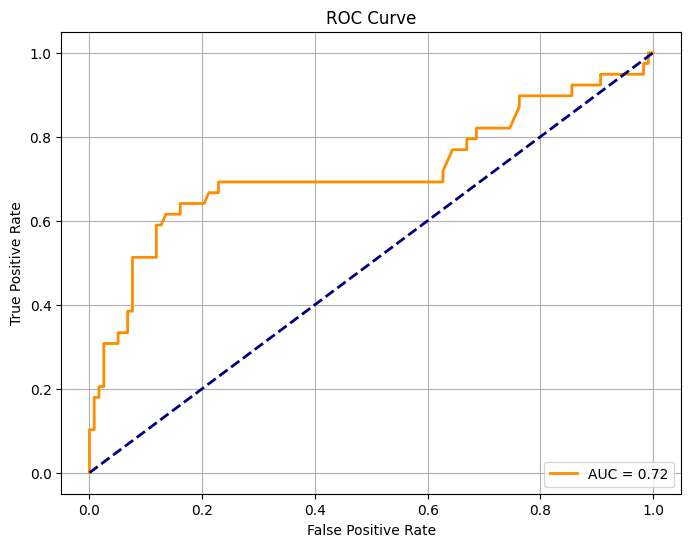

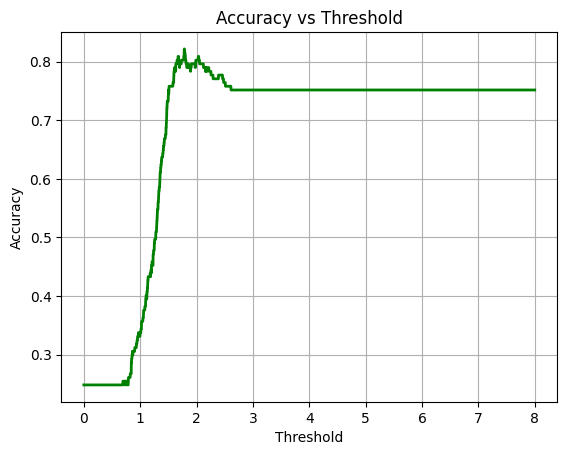

AUC: 0.7164276401564537
Max Accuracy: 0.8217 at threshold 1.7819


In [ ]:
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import matplotlib.pyplot as plt

# Linearly sample 3000 threshold choices between 0 and 8
threshold_choices = np.linspace(0, 8, num=3000)

# Initialize arrays
tpr_scores = []
fpr_scores = []
accuracy_scores = []

# Iterate over thresholds
for threshold in threshold_choices:
    # Classify as anomalous or not
    predicted_labels = np.where(test_error_values <= threshold, 0, 1)

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Store metrics
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)
    accuracy_scores.append(accuracy)

# Compute AUC
roc_auc = auc(fpr_scores, tpr_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_scores, tpr_scores, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#plot Accuracy vs Threshold
plt.figure()
plt.plot(threshold_choices, accuracy_scores, color='green', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)
plt.show()

print("AUC:", roc_auc)
print("Max Accuracy: {:.4f} at threshold {:.4f}".format(
    max(accuracy_scores), threshold_choices[np.argmax(accuracy_scores)]
))


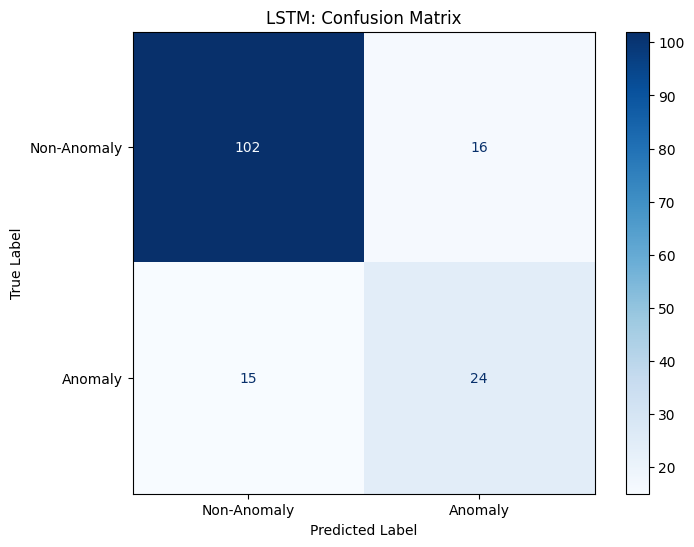

In [ ]:
predicted_labels = np.where(test_error_values <= best_threshold, 0, 1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Non-Anomaly', 'Anomaly'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Customize the plot
plt.title('LSTM: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [ ]:
predicted_labels = np.where(test_error_values <= best_threshold, 0, 1)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print('Accuracy:', accuracy) # (TP + TN)/Total = (53+48)/134

print('Precision:', precision) # TP/(TP + FP) = 53/(53+30)

print('Recall', recall) # TP/(TP + FN) = 53/(53+3)

print('F1 score', f1)

Accuracy: 0.802547770700637
Precision: 0.6
Recall 0.6153846153846154
F1 score 0.6075949367088608
